In [1]:
%run setup.ipynb
random.seed(42)
np.random.seed(42)
from pathlib import Path

In [2]:
def snp_select():
    
    callset = phase2_ar1.callset_pass_biallelic['3L']

    regions = (("3R", 1000000, 37000000, "free"),
               ("3L", 15000000, 41000000, "free"))

    chrom = '3L'

    #get genotypes
    g = allel.GenotypeChunkedArray(callset['calldata']['genotype'])

    #get positions
    p = allel.VariantChunkedTable(callset['variants'],
                                     names=['POS'],
                                     index='POS')
    pos = p.POS[:]

    #just keep positions within the free region
    pos_free = pos[(pos > 15000000) * (pos < 41000000)] 
    free_b = p.index.locate_keys(pos_free)
    g_snp = g.compress(free_b, axis=0)

    #filter - no missing data
    ac = g_snp.count_alleles()
    flt = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 1)
    gf = g_snp.compress(flt, axis=0)

    #turn the genotype array into 2D matrix of non_ref alleles per call
    gn = gf.to_n_alt()

    #randomly select snps
    n = 100000
    vidx = np.random.choice(gn.shape[0], n, replace=False)
    vidx.sort()
    gnr = gn.take(vidx, axis=0)
    
    return gnr



def ld_prune(gn, size, step, threshold=.1, n_iter=1):
    for i in range(n_iter):
        loc_unlinked = allel.locate_unlinked(gn, size=size, step=step, threshold=threshold)
        n = np.count_nonzero(loc_unlinked)
        n_remove = gn.shape[0] - n
        print('iteration', i+1, 'retaining', n, 'removing', n_remove, 'variants')
        gn = gn.compress(loc_unlinked, axis=0)
    return gn

In [3]:
pca_data = Path('pca_data.npz')

In [4]:
if pca_data.is_file():
    # file exist
    print('pook')
    pca = np.load('pca_data.npz')
    coords = pca['coords']
    loadings = pca['loadings']
    variance = pca['variance']
else:
    print('snook')
    gnr = snp_select()
    gnu = ld_prune(gnr, size=500, step=200, threshold=.1, n_iter=10)
    coords, model = allel.pca(gnu, n_components=20, scaler='patterson')


pook


## for figure - run from here

In [5]:
marker_style = {
    'GHcol' : 'D',
    'GHgam' : 'o',
    'BFgam' : 'o',
    'BFcol' : 'D',
    'UGgam' : 'o',
    'GM' : '*',
    'GW' : '*',
    'KE' : '*',
    'CMgam' : 'o',
    'FRgam' : 'o', 
    'GQgam' : 'o', 
    'AOcol' : 'D', 
    'GAgam' : 'o', 
    'GNgam' : 'o', 
    'GNcol' : 'D', 
    'CIcol' : 'D'
}

In [6]:
#get samples
df_samples = pd.read_csv('../phase2.AR1/samples/samples.meta.txt', delimiter='\t')
all_samp=list(df_samples.ox_code)

In [7]:
all_samp=list(df_samples.ox_code)
len(all_samp)

1142

In [8]:
populations = list(phase2_ar1.pop_labels.keys())
populations.remove('colony')

In [9]:
#dictionary+list comprehension to create a dictionary of lists of indexes!
idx_dict = {popz: [i for i, j in enumerate(all_samp) if j == popz] for popz in populations}

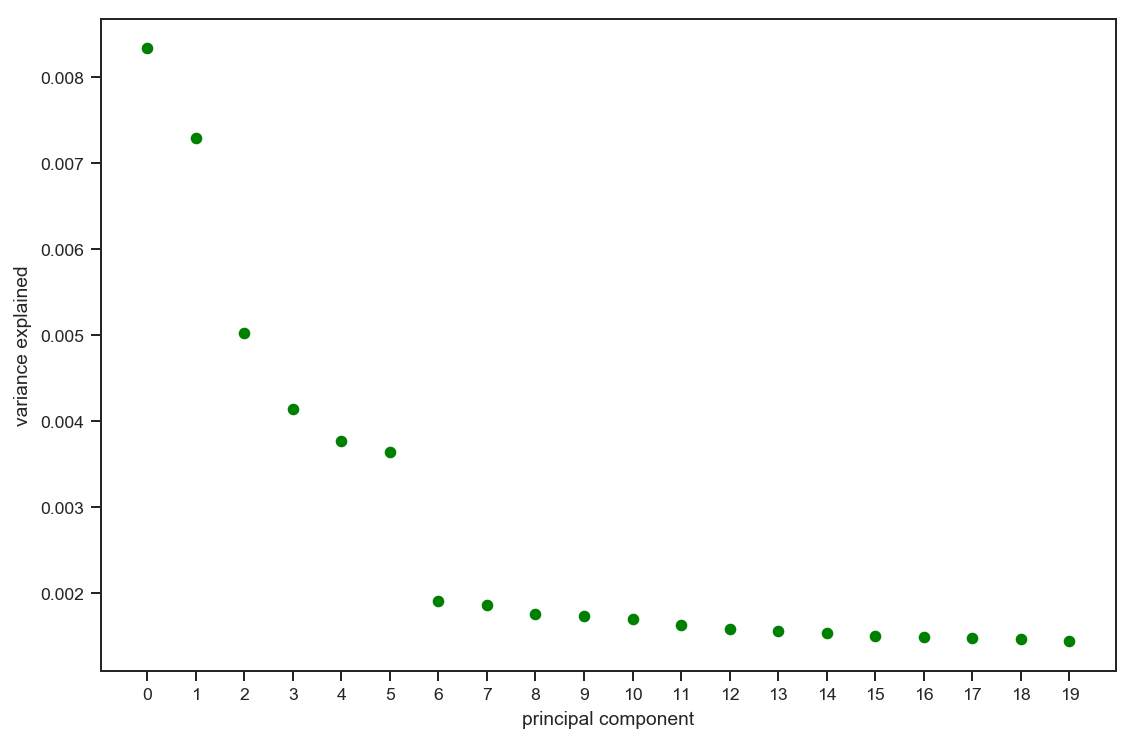

In [10]:
fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(121)
if 'variance' in globals():
    ax.plot(variance, 'go')
else:
    ax.plot(model1.explained_variance_ratio_, 'go')
ax.set_xlabel("principal component")
ax.set_ylabel("variance explained")
plt.xticks(np.arange(0,20, 1));

In [11]:
def plot_pca_coords(coords, model, pc1, pc2, ax, sample_population):
    sns.despine(ax=ax, offset=5)
    x = coords[:, pc1]
    y = coords[:, pc2]
    for pop in populations:
        flt = (sample_population == pop)
        ax.plot(x[flt], y[flt], marker=marker_style[pop], linestyle=' ', color=phase2_ar1.pop_colors[pop], label=pop, markersize=6, mec='k', mew=0.5)
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model[pc2]*100))
    

def fig_pca(coords, model, title, sample_population):
    # plot coords for PCs 1 vs 2, 3 vs 4
    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(231)
    plot_pca_coords(coords, model, 0, 1, ax, sample_population)

    ax = fig.add_subplot(232)
    plot_pca_coords(coords, model, 2, 3, ax, sample_population)
    
    ax = fig.add_subplot(233)
    plot_pca_coords(coords, model, 4, 5, ax, sample_population)
    
    ax = fig.add_subplot(234)
    plot_pca_coords(coords, model, 6, 7, ax, sample_population)
    
    ax = fig.add_subplot(235)
    plot_pca_coords(coords, model, 8, 9, ax, sample_population)
    
    ax = fig.add_subplot(236)
    plot_pca_coords(coords, model, 10, 11, ax, sample_population)

    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
    
    fig.suptitle(title, y=1.02)
    fig.tight_layout()
#     fn = 'Phase_2_3L_pca.jpeg'
#     fig.savefig(fn, jpeg_quality=100, dpi=100, bbox_inches='tight')

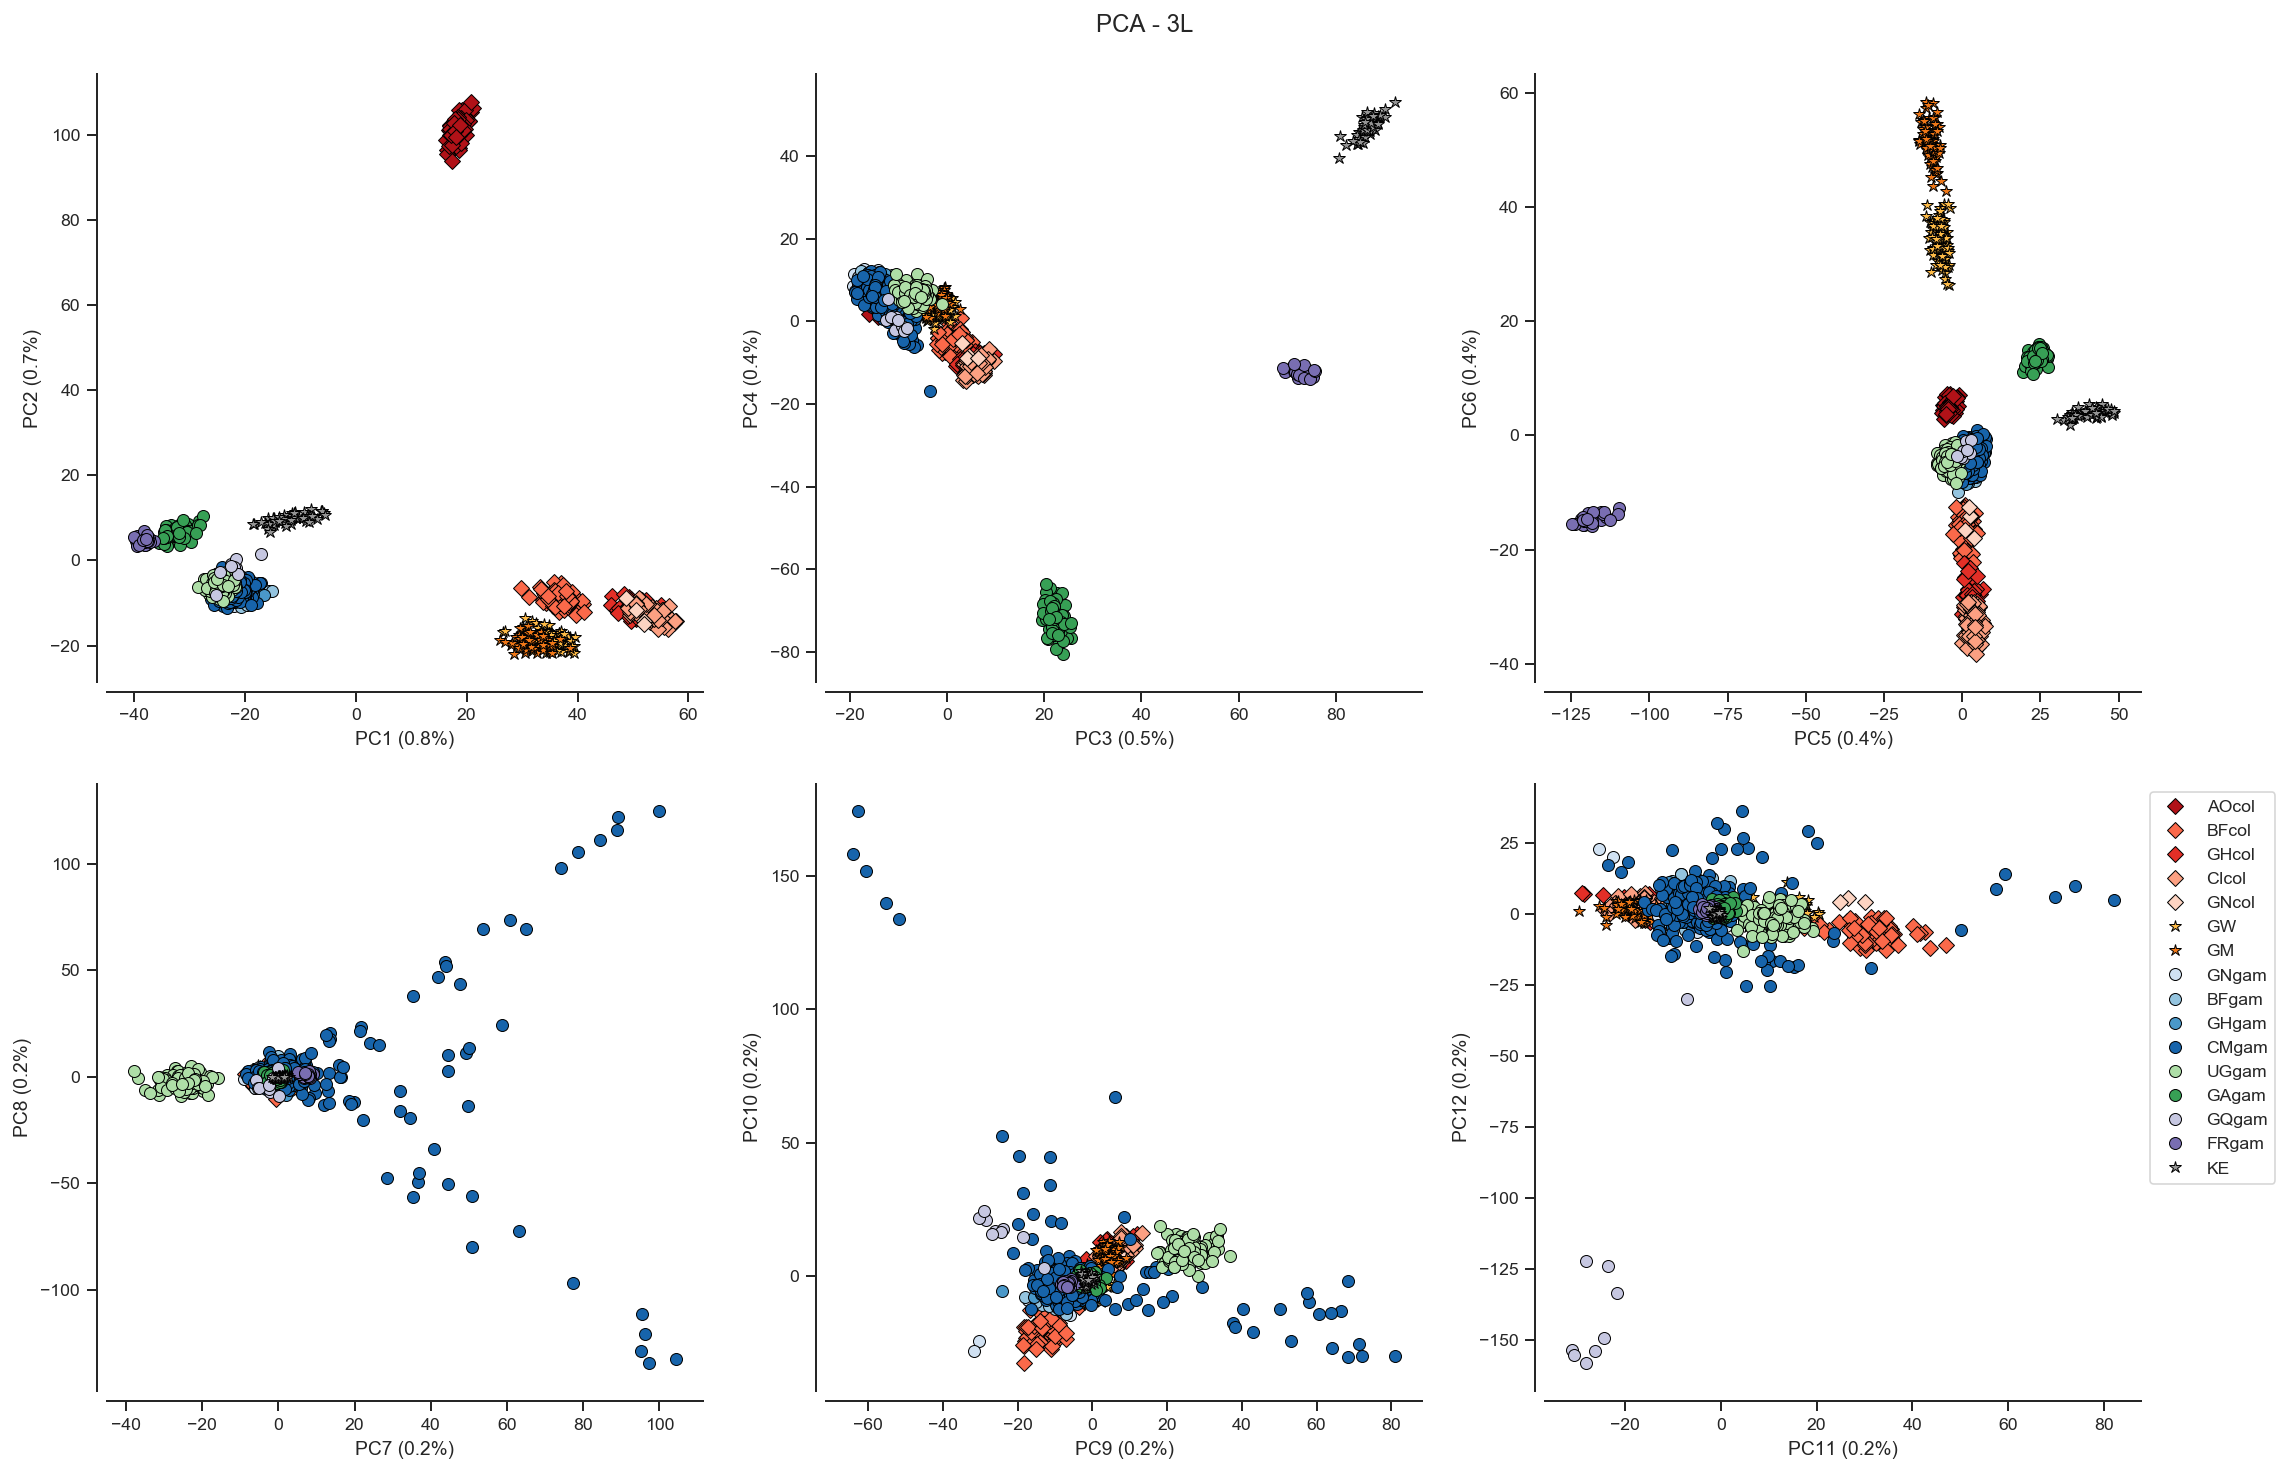

In [12]:
if 'variance' in globals():
    fig_pca(coords, variance ,'PCA - 3L', df_samples.population.values)
else:
    fig_pca(coords1, model1.explained_variance_ratio_ ,'PCA - 3L', df_samples.population.values)

## main text figure

In [13]:
def fig_main_pca(coords, model, title, sample_population):
    fig = plt.figure(figsize=(12, 5))
    
    ax = fig.add_subplot(121)
    plot_pca_coords(coords, model, 0, 1, ax, sample_population)
    for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(10)

    ax = fig.add_subplot(122)
    plot_pca_coords(coords, model, 2, 3, ax, sample_population)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(10)
    
    ax.legend(bbox_to_anchor=(1, 1.04), loc='upper left', fontsize=13, framealpha=0.1)
    fig.tight_layout()
    fn = '../artwork/pca_3L_main_text.jpeg'
    fig.savefig(fn, jpeg_quality=100, dpi=100, bbox_inches='tight')

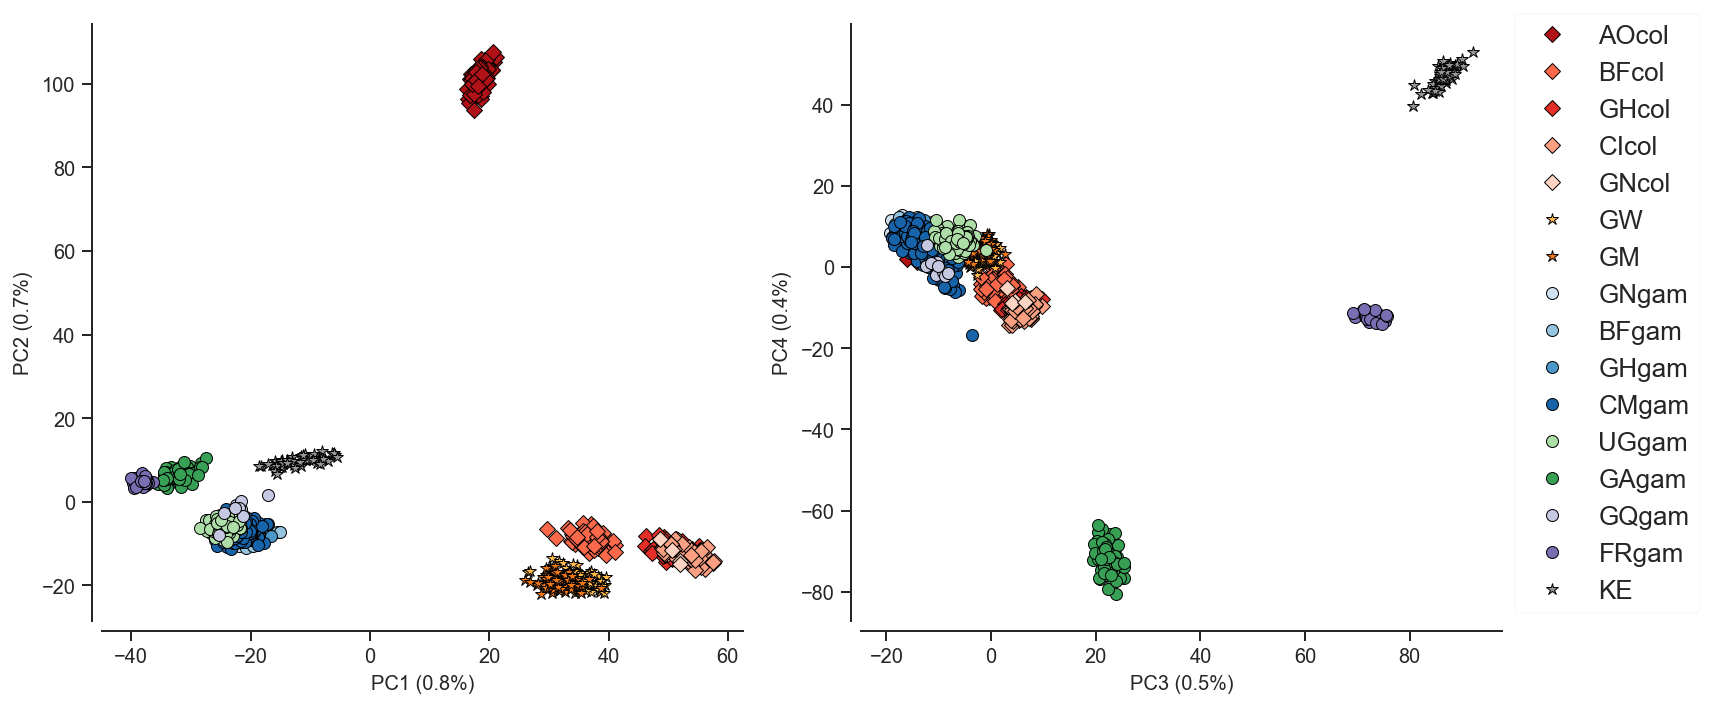

In [14]:
if 'variance' in globals():
    fig_main_pca(coords, variance ,'PCA - 3L', df_samples.population.values)
else:
    fig_main_pca(coords1, model1.explained_variance_ratio_ ,'PCA - 3L', df_samples.population.values)

## supplementary figure

In [15]:
def fig_supp_pca(coords, model, title, sample_population):
    
    fig = plt.figure(figsize=(18, 5))
    
    ax = fig.add_subplot(131)
    sns.despine(ax=ax, offset=5)
    if 'variance' in globals():
        x = np.arange(variance.shape[0])
        y = variance * 100
    else:
        x = np.arange(model1.explained_variance_ratio_.shape[0])
        y = model1.explained_variance_ratio_ * 100
    ax.bar(x+.2, y, width=.6, align='edge', color='darkgray')
    ax.set_xticks(x+.5)
    ax.set_xticklabels(x+1, fontsize=7)
    ax.set_ylabel('Variance explained (\%)')
    ax.set_xlabel('Principal component')
    ax.set_xlim(0, 20)
    for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(10)
        
    ax = fig.add_subplot(132)
    plot_pca_coords(coords, model, 4, 5, ax, sample_population)
    for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(10)

    ax = fig.add_subplot(133)
    plot_pca_coords(coords, model, 6, 7, ax, sample_population)
    for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(10)
    
    ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left', fontsize=12, framealpha=0.1)
    
    fig.tight_layout()
    fn = '../artwork/pca_3L_supplementary.jpeg'
    fig.savefig(fn, jpeg_quality=100, dpi=100, bbox_inches='tight')

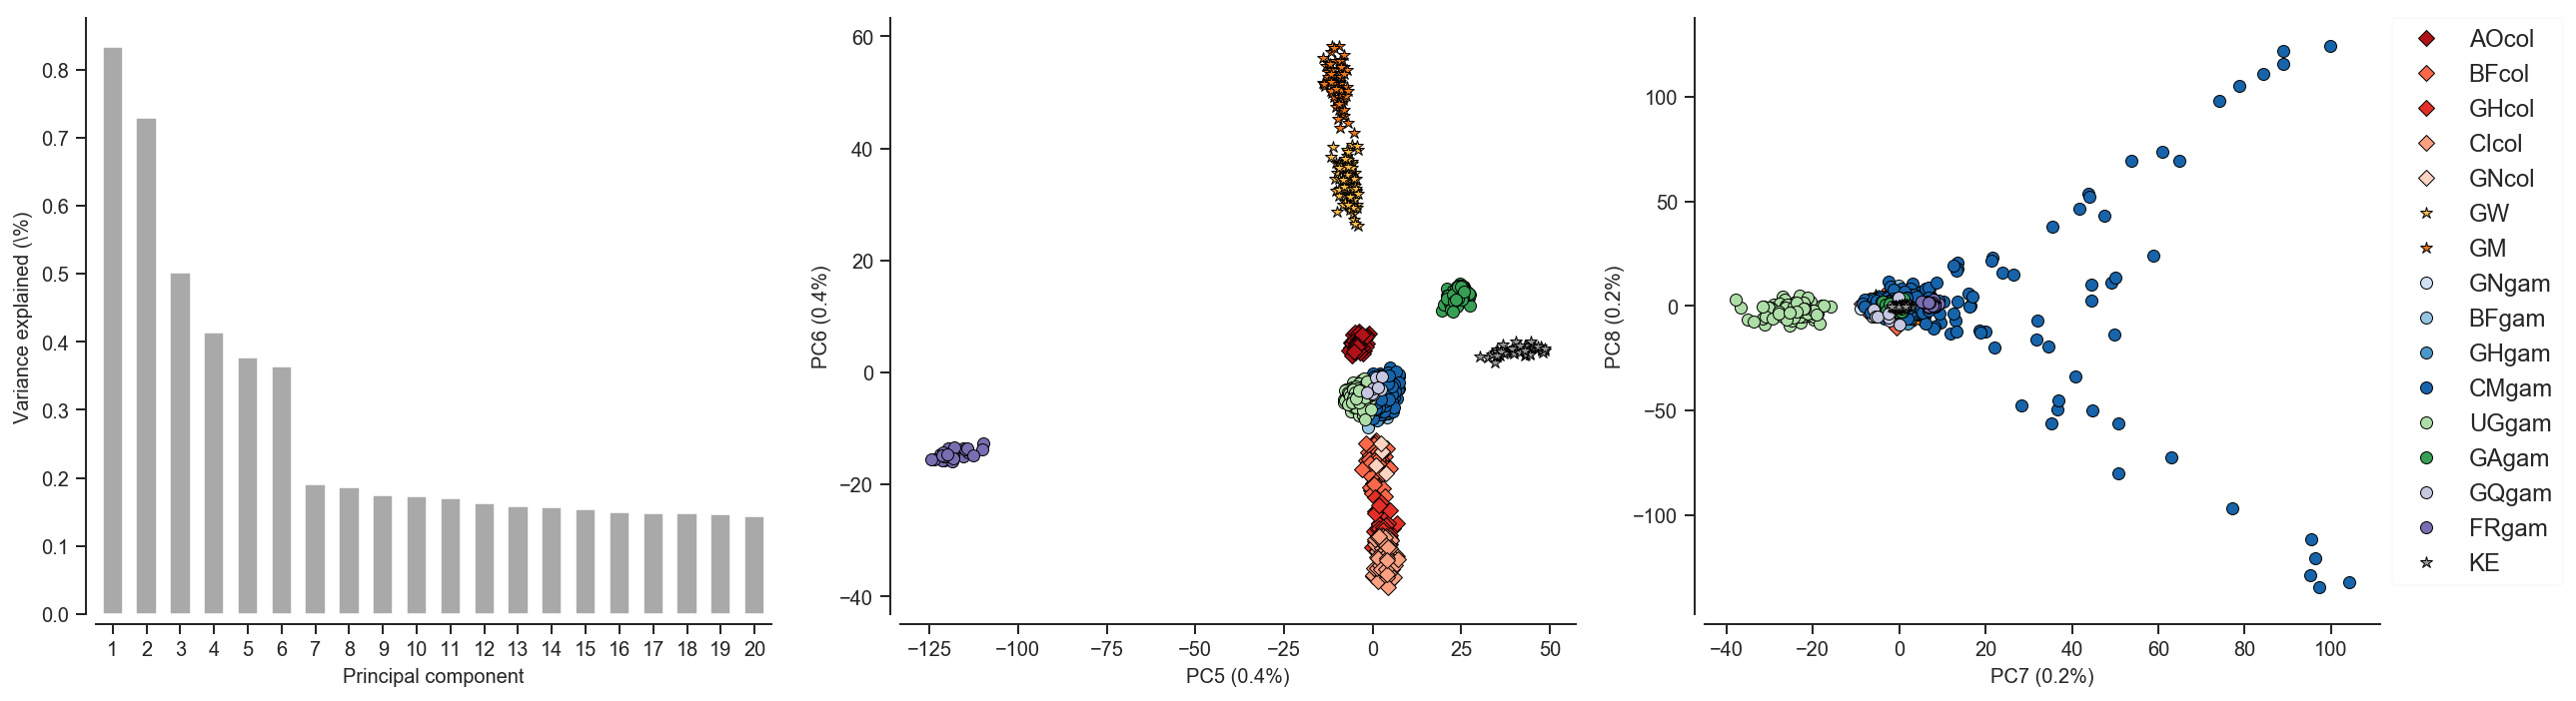

In [16]:
if 'variance' in globals():
    fig_supp_pca(coords, variance ,'PCA - 3L', df_samples.population.values)
else:
    fig_supp_pca(coords1, model1.explained_variance_ratio_ ,'PCA - 3L', df_samples.population.values)

## bokeh

In [17]:
coords.shape, variance.shape

((1142, 20), (20,))

In [18]:
bmeta = pd.read_table(
    "../phase2.AR1/samples/samples.meta.txt")[['ox_code', 'population', 'country', 'year']]
bmeta.head()

,ox_code,population,country,year
0,AA0040-C,GHcol,Ghana,2012.0
1,AA0041-C,GHcol,Ghana,2012.0
2,AA0042-C,GHcol,Ghana,2012.0
3,AA0043-C,GHcol,Ghana,2012.0
4,AA0044-C,GHcol,Ghana,2012.0


In [19]:
# imports required for `bokeh`
from bokeh.plotting import figure, show, ColumnDataSource, output_file
from bokeh.layouts import gridplot

In [20]:
def plot_pca_coords(coords, variance, pc1, pc2, fig, populations):

    x = coords[:, pc1]
    y = coords[:, pc2]
    
    qdf = bmeta.copy()
    qdf["x"] = x
    qdf["y"] = y
    
    for pop in populations:
        
        source = ColumnDataSource(
            data=qdf.query("population == @pop"))
        
        fig.circle(
            'x', 'y', 
            source=source,
            line_color='black',
            line_width=0.5,
            size=6,
            fill_color=mpl.colors.rgb2hex(phase2_ar1.pop_colors[pop]))
    
    fig.xaxis.axis_label = 'PC {0} ({1:.2f}%)'.format(
        pc1 + 1, 100 * variance[pc1])
    
    fig.yaxis.axis_label = 'PC {0} ({1:.2f}%)'.format(
        pc2 + 1, 100 * variance[pc2])
    
    return fig

In [21]:
components = np.array(range(8)).reshape((2, 2, 2)).tolist()

In [22]:
components

[[[0, 1], [2, 3]], [[4, 5], [6, 7]]]

In [23]:
# This defines what is displayed when the mouse hovers over a point.
# The @ values correspond to values in the table.
TOOLTIPS = [
    ("ox_code", "@ox_code"),
    ("population", "@population"),
    ("collection year", "@year"),
    ("(x, y)", "($x, $y)"),]

In [24]:
output_file("pca_plots.html")
grid = []

for row in components:
    
    l = []
    
    for (c1, c2) in row:

        p = figure(plot_width=400, plot_height=400, tooltips=TOOLTIPS)
        l.append(plot_pca_coords(coords, variance, c1, c2, p, populations))
        
    grid.append(l)

col = gridplot(grid)
show(col)

In [25]:
from IPython.display import HTML
HTML(filename="pca_plots.html")